<a href="https://colab.research.google.com/github/shailavij/ML-Projects/blob/master/CIFAR_CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import Libararies
import torch
import numpy as np
from torchvision import transforms,datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# normalize the data
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [0]:
# Download a& Load data
train_data=datasets.CIFAR10('data',train=True,download=True,transform=trans)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=trans)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# Obtain train_indices that will be used for validation
num_train=len(train_data)
indices=list(range(num_train))
num_train

50000

In [0]:
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))
split


10000

In [0]:
# split train , Valid data
train_idx,valid_idx=indices[split:],indices[:split]



In [0]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
# Visualize a Batch of Training Data
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

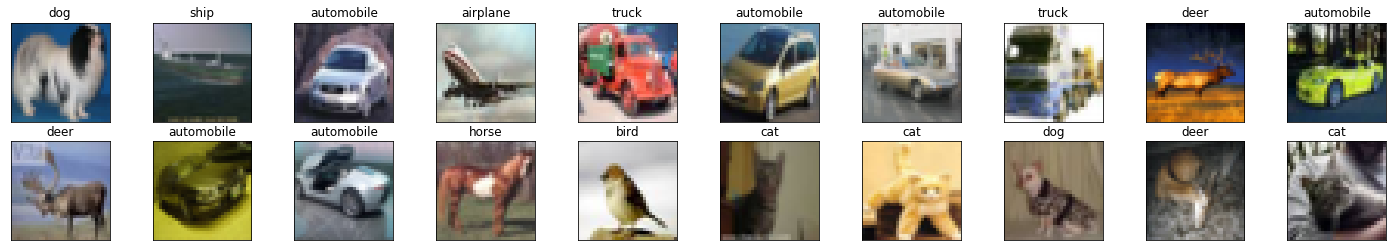

In [0]:
# Obtain 1 batch of image
dataiter=iter(train_loader)
images,label=dataiter.next()
images=images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig= plt.figure(figsize=(25,4))
# Display 20 image 
for i in range(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  imshow(images[i])
  ax.set_title(classes[label[i]])


In [0]:
pip install pytorch-model-summary

define a CNN architecture

Convolution layer: Its a stack of filtered image

Maxpooling Layer: Which reduce X-Y size of input image , keeping only active pixel from previous layer
Linear & Dropout layers are used to avoid overfitting and produce 10 dim output

Note : More conv. layer includes in architecture makes model to detect many patterns  and shapes.

output size of a given convolutional layer :
compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by
 
(W−F+2P)/S+1.



In [0]:
import torch.nn as nn
import torch.nn.functional as F
from pytorch_model_summary import summary

# Define architecture
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    # Conv. layer see input(32*32*3) image tensor
    self.conv1=nn.Conv2d(3,16,3,stride=1, padding=1)

    # Conv. layer see input(16*16*16) image tensor
    self.conv2=nn.Conv2d(16,32,3, stride=1, padding=1)

    # Conv. layer see input(8*8*32) image tensor
    self.conv3=nn.Conv2d(32,64,3, stride=1, padding=1)
    # Max pooling layer
    self.pool=nn.MaxPool2d(2,2)
    # Linear layer 1 (64 * 4 * 4 -> 500)
    self.fc1=nn.Linear(64 * 4 * 4,500)
    # Linear layer 2 (500--> 10)
    self.fc2=nn.Linear(500,10) 
    self.dropout=nn.Dropout(0.25)   
           
  def forward(self, x):
    # Add sequuence of input & Conv.layer
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    # flatten image input
    x=x.view(-1,64 * 4 * 4)
    # Add dropout layer
    x=self.dropout(x)
    # add 1st hidden layer, with relu activation function
    x=F.relu(self.fc1(x))
     # Add dropout layer
    x=self.dropout(x)
    # add 1st hidden layer, with relu activation function
    x=F.relu(self.fc2(x))
    return x


# Create complete CNN
model=Net()
print(model)

# show output shape and hierarchical view of net

print(summary(Net(), torch.zeros((10,3, 32, 32)), show_input=True))



Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1      [10, 3, 32, 32]             448             448
       MaxPool2d-2     [10, 16, 32, 32]               0               0
          Conv2d-3     [10, 16, 16, 16]           4,640           4,640
       MaxPool2d-4     [10, 32, 16, 16]               0               0
          Conv2d-5       [10, 32, 8, 8]          18,496          18,496
     

# Define Loss & Optimiser


In [0]:
import torch.optim as optim

# Specifies loss function as crossentropy loss
crit= nn.CrossEntropyLoss()

# Specified optimiser
optimizer=optim.SGD(model.parameters(),lr=0.01)

In [0]:
# train the Network
# Number of Epochs to train the model
n_epoch=30

# Track change in Vlaidation loss
valid_loss_min= np.Inf

for epoch in range(1, n_epoch+1):
  # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###############
    # TRian the Model
    ######################

    for data, label in train_loader:
      # Clear gradient of all ootimized values
      optimizer.zero_grad()
      # Forwardpass compute predicted value to model
      output = model(data)
      # Compute batch Loss
      loss=crit(output,label)
      # Backward pass:Compute gradient of the loss w.r.to model parameter
      loss.backward()
      ## perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)


    ###########
    #Validate Model
    ###################

    for data , label in valid_loader:
      # Forwardpass compute predicted value to model
      output = model(data)
      # Compute batch Loss
      loss=crit(output,label)  
      # update validation loss
      valid_loss += loss.item()*data.size(0)

      # Calculate avaerage loss
      train_loss=train_loss/len(train_loader.sampler)
      valid_loss=valid_loss/len(valid_loader.sampler)   

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss








Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.004033
Validation loss decreased (inf --> 0.004033).  Saving model ...
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 0.003181
Validation loss decreased (0.004033 --> 0.003181).  Saving model ...
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.003676
Epoch: 4 	Training Loss: 0.000000 	Validation Loss: 0.002724
Validation loss decreased (0.003181 --> 0.002724).  Saving model ...
Epoch: 5 	Training Loss: 0.000000 	Validation Loss: 0.002223
Validation loss decreased (0.002724 --> 0.002223).  Saving model ...
Epoch: 6 	Training Loss: 0.000000 	Validation Loss: 0.002015
Validation loss decreased (0.002223 --> 0.002015).  Saving model ...
Epoch: 7 	Training Loss: 0.000000 	Validation Loss: 0.002049
Epoch: 8 	Training Loss: 0.000000 	Validation Loss: 0.003297
Epoch: 9 	Training Loss: 0.000000 	Validation Loss: 0.002278
Epoch: 10 	Training Loss: 0.000000 	Validation Loss: 0.001832
Validation loss decreased (0.002015 --> 0.001832)

In [0]:
#Load the Model with the Lowest Validation Loss

model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [0]:

#Test the Trained Network
#Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.#

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
  
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = crit(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.780315

Test Accuracy of airplane: 78% (785/1000)
Test Accuracy of automobile: 82% (828/1000)
Test Accuracy of  bird: 58% (589/1000)
Test Accuracy of   cat: 51% (519/1000)
Test Accuracy of  deer: 66% (669/1000)
Test Accuracy of   dog: 59% (591/1000)
Test Accuracy of  frog: 87% (872/1000)
Test Accuracy of horse: 76% (766/1000)
Test Accuracy of  ship: 84% (846/1000)
Test Accuracy of truck: 80% (802/1000)

Test Accuracy (Overall): 72% (7267/10000)


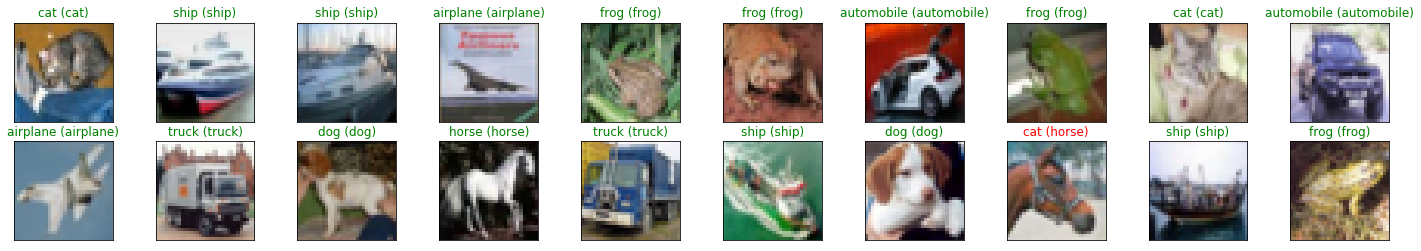

In [0]:
#Visualize Sample Test Results
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()



# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))